In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data_ED = 'drive/MyDrive/CMRI/training ED/'

In [ ]:
os.listdir(data_ED)

['train.pickle', 'val.pickle', 'dataset']

# Load Pickle File

In [ ]:
with open(os.path.join(data_ED, 'train.pickle'), 'rb') as f:
  train_data = pickle.load(f)
  del train_data['y_processed']

with open(os.path.join(data_ED, 'val.pickle'), 'rb') as f:
  val_data = pickle.load(f)
  del val_data['y_processed']

In [ ]:
train_data['x'].shape, train_data['y'].shape

((763, 256, 256), (763, 256, 256))

# Visualization

In [ ]:
def highlight_classes(image, mask):
    # Define colors for each class
    class_colors = {
        1: 0,    # Right Ventricle
        2: 127.5,    # Myocardium
        3: 255,    # Left Ventricle
    }

    # convert mask labels to integer
    mask = mask.astype(int)

    # Create a new image for visualization
    visualized_image = np.copy(image)

    # Loop through each pixel in the mask
    for row in range(mask.shape[0]):
        for col in range(mask.shape[1]):
            pixel_class = mask[row, col]

            # Check if the pixel class is 0-2
            if pixel_class in class_colors.keys():
                # Get the corresponding color for the class
                color = class_colors[pixel_class]

                # Highlight the pixel in the visualized image
                visualized_image[row, col] = color

    return visualized_image

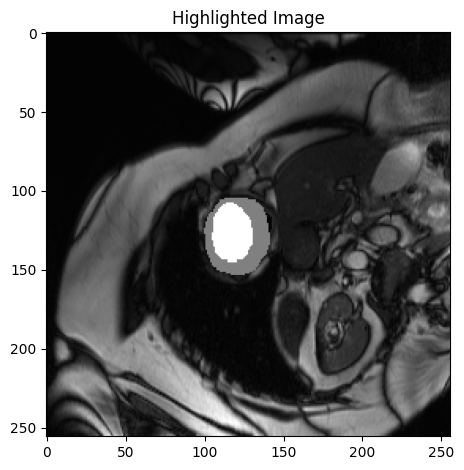

In [ ]:
# Load your image and mask
idx = 5
image = train_data['x'][idx]
mask = train_data['y'][idx]

# Call the function to generate the highlighted image
highlighted_image = highlight_classes(image, mask)

# Display highlighted image
plt.imshow(highlighted_image, cmap='gray')
plt.title("Highlighted Image")

plt.tight_layout()
plt.show()

# Preprocess Input

In [ ]:
train_data['x'] = np.expand_dims(train_data['x'], -1)
val_data['x'] = np.expand_dims(val_data['x'], -1)
train_data['y'] = np.expand_dims(train_data['y'], -1)
val_data['y'] = np.expand_dims(val_data['y'], -1)

In [ ]:
train_data['x'].shape, train_data['y'].shape

((763, 256, 256, 1), (763, 256, 256, 1))

# Build UNET Architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate

def unet(input_shape, input_channels, num_classes):
    inputs = Input(shape=(input_shape[0], input_shape[1], input_channels))

    # Encoder path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottom of the U shape
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder path
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), activation='relu', padding='same')(conv5)
    merge6 = Concatenate()([conv4, up6])
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), activation='relu', padding='same')(conv6)
    merge7 = Concatenate()([conv3, up7])
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), activation='relu', padding='same')(conv7)
    merge8 = Concatenate()([conv2, up8])
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), activation='relu', padding='same')(conv8)
    merge9 = Concatenate()([conv1, up9])
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer with the number of classes defined
    outputs = Conv2D(num_classes, 1, activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = unet((256,256),1,4) #input channel 1 dan output channel nya 4

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

# Modelling

In [ ]:
def preprocess_input(x):
  #Normalize the input values to the range [0,1]
  return x / 255.0

def preprocess_output(y):
  #Convert categorical labels to one-hot encoded masks
  return tf.keras.utils.to_categorical(y, num_classes=4)

def preprocess_output1(y):
    y = tf.cast(y, tf.int32)
    y_onehot = tf.one_hot(y, 4)  # Convert to one-hot encoding
    return y_onehot

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.backend import epsilon

def save_logging(path, text):
  with open(path, 'a') as f:
    f.writelines(text+'\n')

def has_all_zeros(tensor):
    return tf.reduce_all(tensor == 0)

def dice_score_per_class(y_true, y_pred, num_classes=4, sample_weight=None):
    y_true = preprocess_output1(y_true)

    dice_scores = []
    for class_id in range(num_classes):
        y_true_class = tf.keras.backend.flatten(y_true[..., class_id])
        y_pred_class = tf.keras.backend.flatten(y_pred[..., class_id])
        intersection = tf.keras.backend.sum(y_true_class * y_pred_class)
        dice_score = (2.0 * intersection + epsilon()) / (tf.keras.backend.sum(y_true_class) + tf.keras.backend.sum(y_pred_class) + epsilon())
        # if has_all_zeros(y_true_class) and has_all_zeros(y_pred_class):
        #   dice_score = tf.ones(dice_score.shape, dice_score.dtype)
        #   dice_scores.append(dice_score)
        # else:
        #   save_logging('log.txt', str(dice_score))
        dice_scores.append(dice_score)

    dice_scores_tensor = tf.stack(dice_scores)
    return dice_scores_tensor


def dice_coefficient(y_true, y_pred): #dice coefficient butuh one hot encoding yang categorical
    y_true = tf.cast(y_true, tf.int32)
    y_true = preprocess_output1(y_true)
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + epsilon()) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + epsilon())

def dice_loss(y_true, y_pred):
    # Define epsilon to prevent division by zero
    epsilon = tf.keras.backend.epsilon()

    # Calculate the sum of y_true and y_pred for each class
    y_true_sum = tf.reduce_sum(y_true, axis=[0, 1, 2])
    y_pred_sum = tf.reduce_sum(y_pred, axis=[0, 1, 2])

    # Calculate the intersection and union of y_true and y_pred
    intersection = tf.reduce_sum(y_true * y_pred, axis=[0, 1, 2])
    union = y_true_sum + y_pred_sum

    # Calculate the Dice coefficient for each class
    dice = (2. * intersection + epsilon) / (union + epsilon)

    # Calculate the weight for each class
    weight = 1. / ((y_true_sum**2) + epsilon)

    # Calculate the generalized Dice loss
    generalized_dice = tf.reduce_sum(weight * dice)
    generalized_dice_loss = 1. - (2. * generalized_dice)

    return generalized_dice_loss

def train_unet(x_train, y_train, x_val, y_val, input_shape, num_classes, batch_size, epochs):
    # Preprocess the training and validation data
    x_train = preprocess_input(x_train)
    x_val = preprocess_input(x_val)

    # y_train = preprocess_output(y_train)
    # y_val = preprocess_output(y_val)

    print(y_train.shape, y_train.dtype)

    # Create and compile the U-Net model
    model = unet(input_shape, input_channels=1, num_classes=num_classes)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy',dice_coefficient])

    # Add Early Stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint(filepath="cmri_unet2D.h5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)

    # # Train the model
    # model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
    #           validation_data=(x_val, y_val), callbacks=[early_stopping])

    # for epoch in range(epochs):
    #     model.fit(x_train, y_train, batch_size=batch_size, epochs=1,
    #               validation_data=(x_val, y_val), callbacks=[early_stopping, checkpoint])


    #         # Get the dice scores per class from the dice_metric
    #     dice_scores_per_class = dice_score_per_class(y_true=y_val, y_pred=model.predict(x_val))

    #     # Convert dice scores to a more readable format
    #     formatted_dice_scores = [f"{score:.4f}" for score in dice_scores_per_class.numpy()]

    #     # Print the dice scores per class
    #     print(f"Epoch {epoch+1}: Dice Scores per Class: {formatted_dice_scores}")

    # Train the model
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
              validation_data=(x_val, y_val), callbacks=[early_stopping,checkpoint])

    return model

Kalau loss-nya turun berarti it works

In [ ]:
model = train_unet(train_data['x'], train_data['y'], val_data['x'], val_data['y'], (256,256), 4, 8, 200)

(763, 256, 256, 1) float64
Epoch 1/200
96/96 [==============================] - ETA: 0s - loss: 0.4762 - accuracy: 0.9656 - dice_coefficient: 0.7706
Epoch 1: val_loss improved from inf to 0.15094, saving model to cmri_unet2D.h5
96/96 [==============================] - 78s 515ms/step - loss: 0.4762 - accuracy: 0.9656 - dice_coefficient: 0.7706 - val_loss: 0.1509 - val_accuracy: 0.9706 - val_dice_coefficient: 0.9020
Epoch 2/200
96/96 [==============================] - ETA: 0s - loss: 0.1443 - accuracy: 0.9671 - dice_coefficient: 0.9371
Epoch 2: val_loss improved from 0.15094 to 0.10766, saving model to cmri_unet2D.h5
96/96 [==============================] - 44s 456ms/step - loss: 0.1443 - accuracy: 0.9671 - dice_coefficient: 0.9371 - val_loss: 0.1077 - val_accuracy: 0.9706 - val_dice_coefficient: 0.9375
Epoch 3/200
96/96 [==============================] - ETA: 0s - loss: 0.1146 - accuracy: 0.9671 - dice_coefficient: 0.9461
Epoch 3: val_loss improved from 0.10766 to 0.10595, saving model 

In [ ]:
sample = val_data['x'][:10]
sample_label = val_data['y'][:10]
sample = preprocess_input(sample)
result = model.predict(sample)

1/1 [==============================] - 6s 6s/step


In [ ]:
result.shape

(10, 256, 256, 4)

In [ ]:
def postprocess_output(one_hot_output):
    # Find the class index with the highest probability for each pixel
    categorical_output = np.argmax(one_hot_output, axis=-1)

    return categorical_output

In [ ]:
out = postprocess_output(result)
out.shape

(10, 256, 256)

sample input


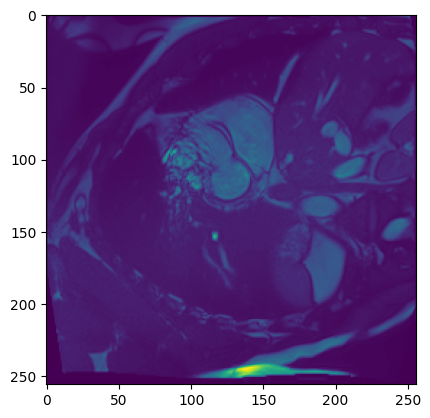

prediction


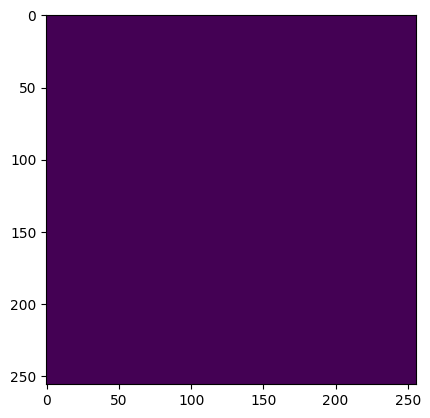

groundtruth


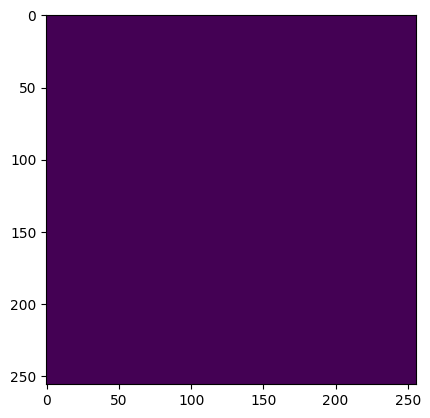

sample input


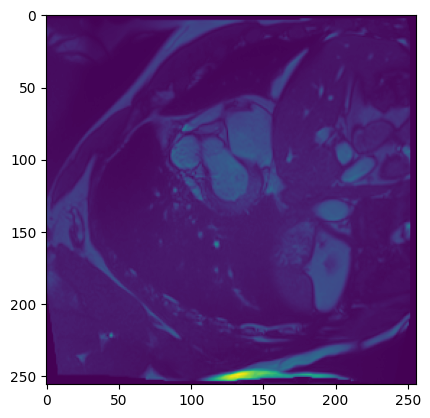

prediction


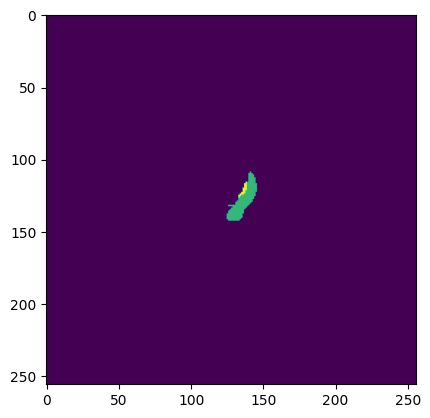

groundtruth


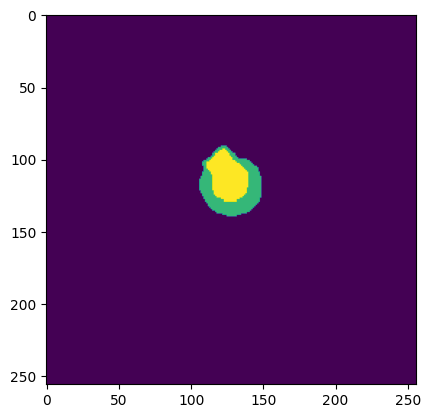

sample input


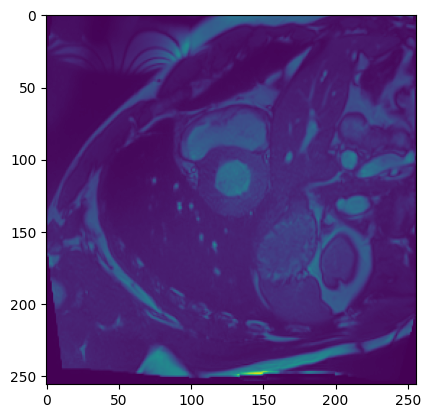

prediction


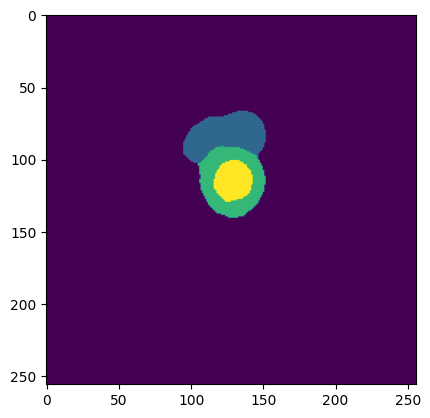

groundtruth


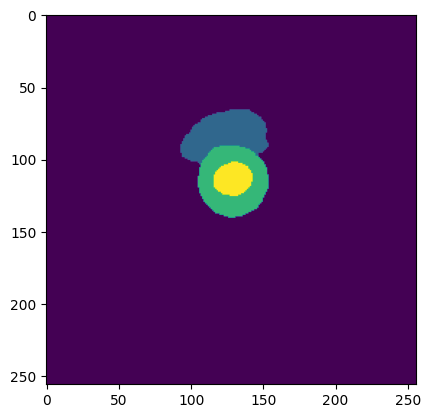

sample input


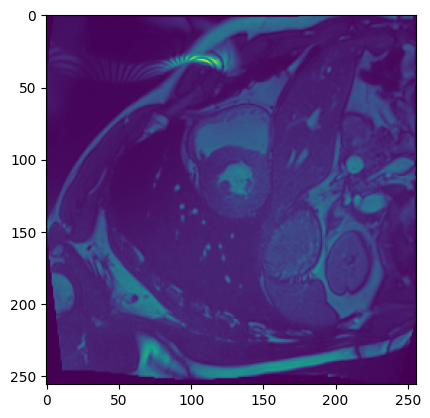

prediction


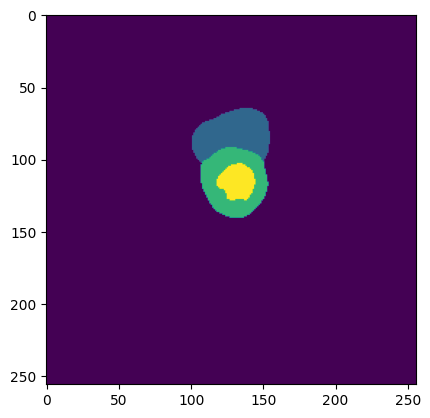

groundtruth


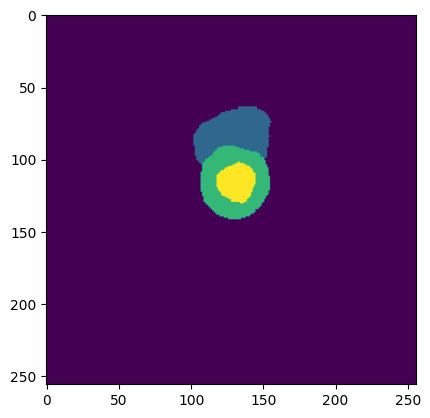

sample input


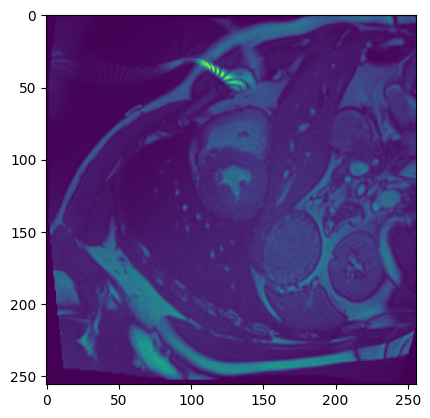

prediction


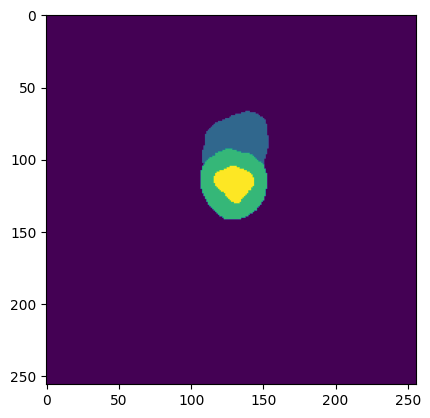

groundtruth


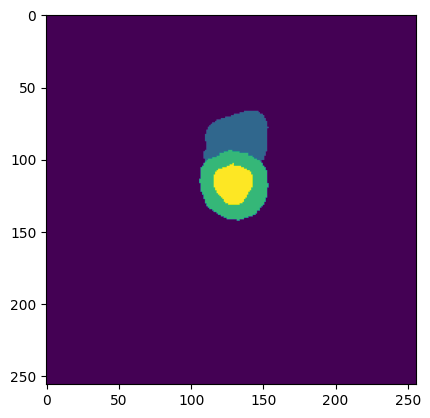

sample input


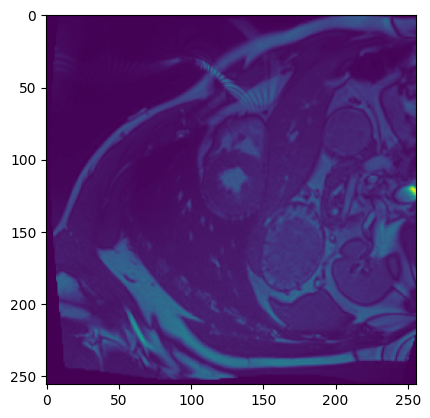

prediction


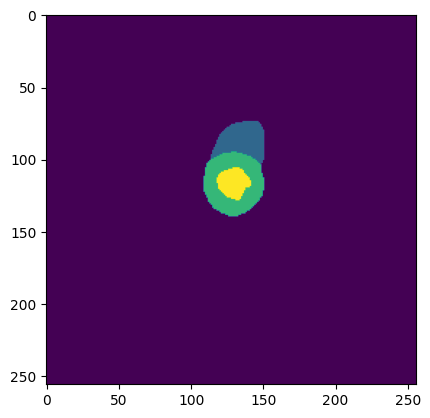

groundtruth


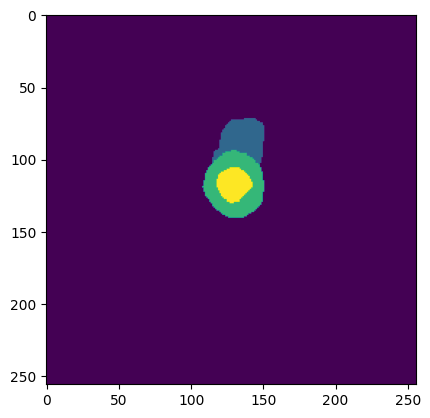

sample input


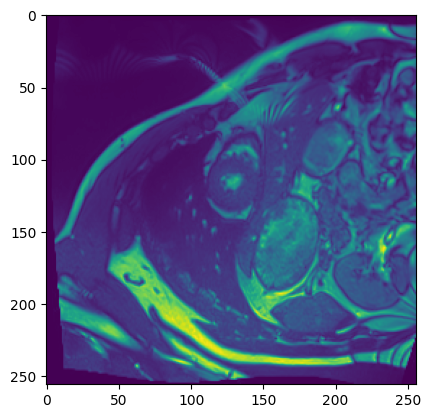

prediction


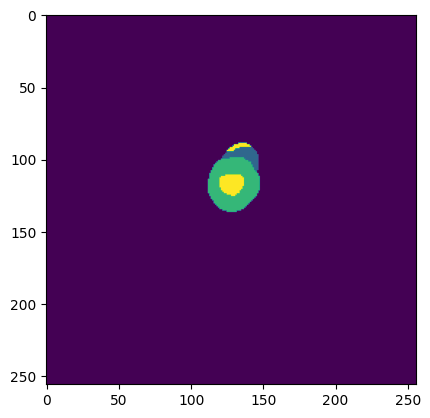

groundtruth


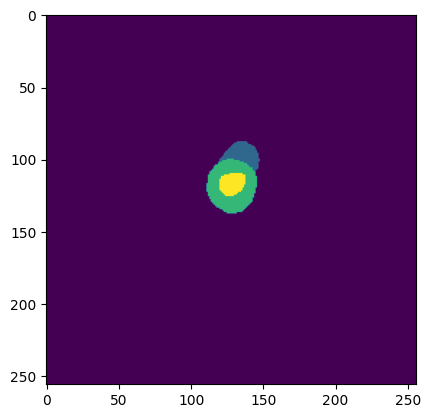

sample input


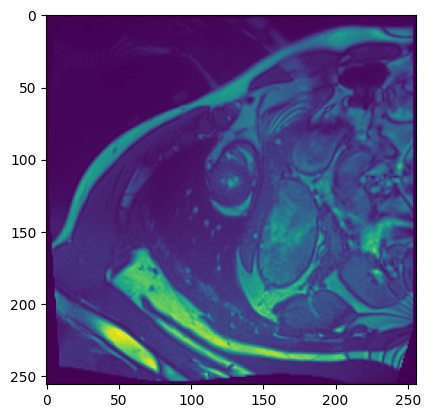

prediction


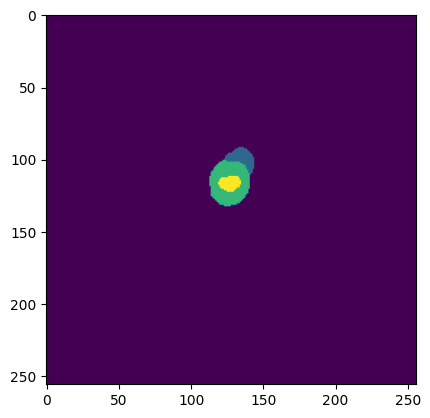

groundtruth


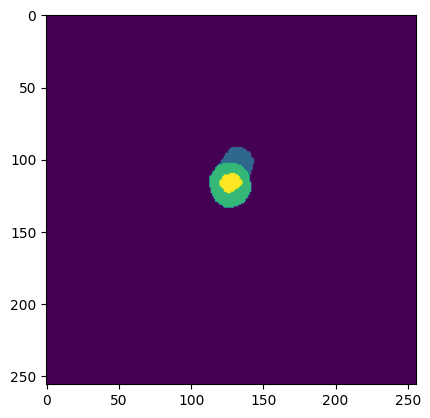

sample input


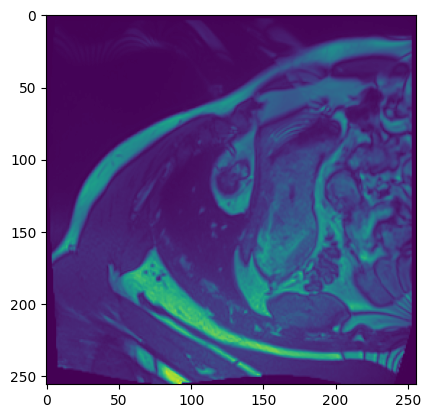

prediction


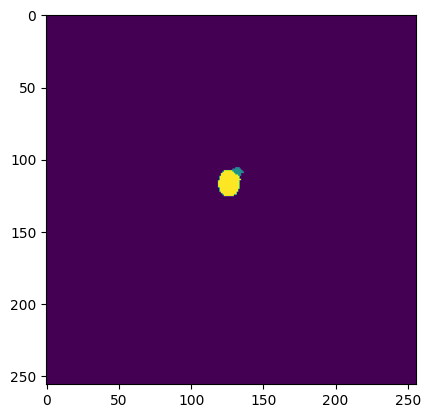

groundtruth


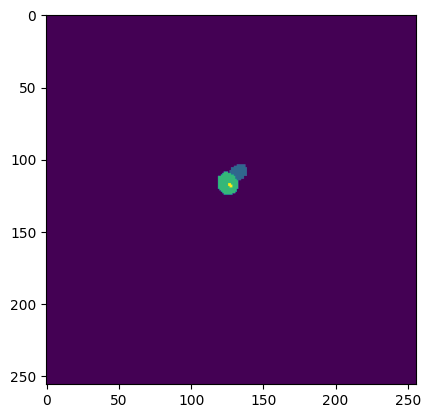

sample input


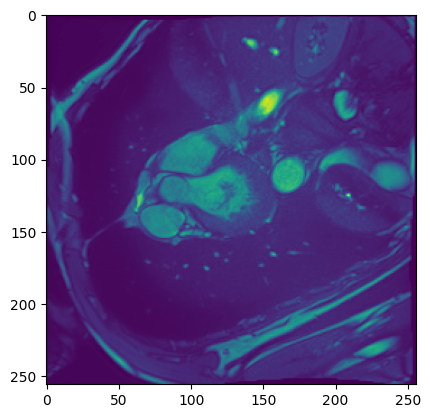

prediction


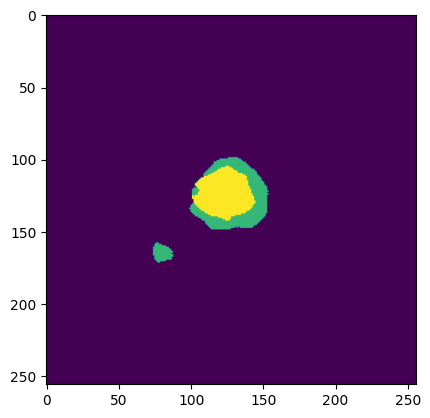

groundtruth


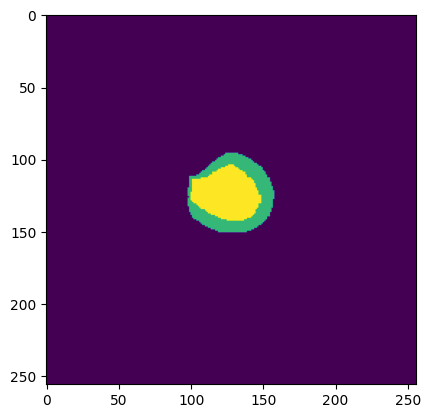

In [ ]:
import matplotlib.pyplot as plt

for s, o, gt in zip(sample, out, sample_label):
  print('sample input')
  s = np.squeeze(s)
  plt.imshow(s)
  plt.show()
  gt = np.squeeze(gt)
  print('prediction')
  plt.imshow(o)
  plt.show()
  print('groundtruth')
  plt.imshow(gt)
  plt.show()

In [ ]:
from keras.utils import to_categorical

In [ ]:
from keras.models import load_model
import random

In [ ]:
x_test = np.expand_dims(val_data['x'] / 255, -1)
y_test = to_categorical(val_data['y'], num_classes=4)

In [ ]:
y_pred = model.predict(val_data['x'])

7/7 [==============================] - 17s 372ms/step


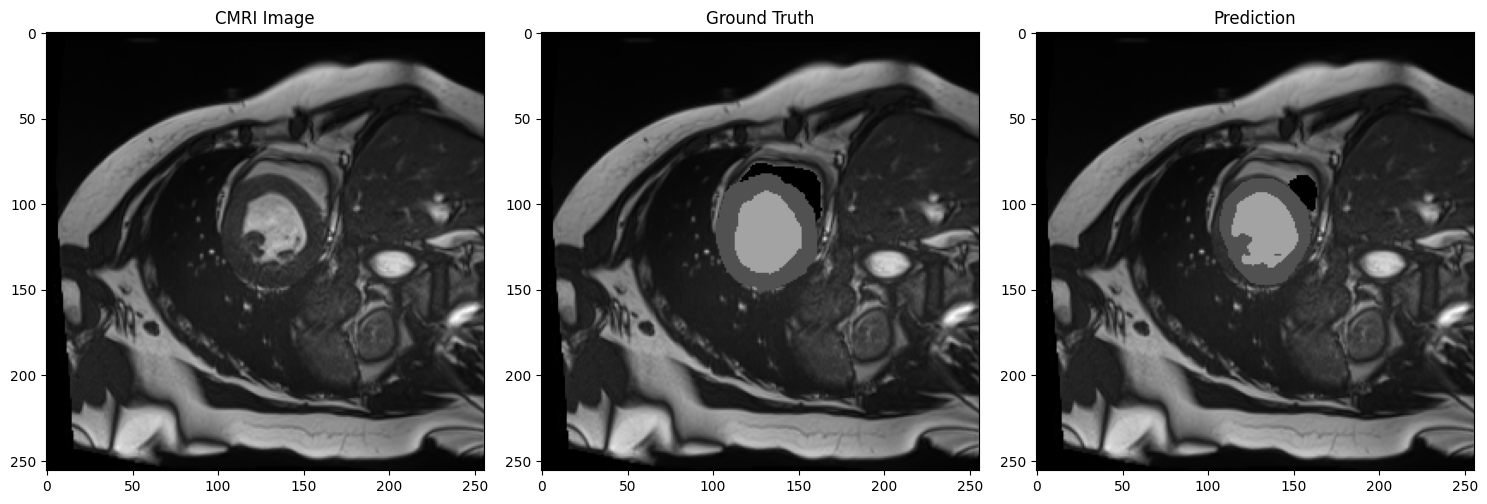

In [ ]:
# Generate random index from testing set
idx = random.randint(0, len(y_pred) - 1)
# Load your image and mask
image = np.squeeze(x_test[idx] * 255)
pred = np.argmax(y_pred[idx], axis=2)
label = np.argmax(y_test[idx], axis=2)

# Call the function to generate the highlighted image
ground_truth = highlight_classes(image, label)
prediction = highlight_classes(image, pred)

# Display highlighted image
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("CMRI Image")

plt.subplot(1, 3, 2)
plt.imshow(ground_truth, cmap='gray')
plt.title("Ground Truth")

plt.subplot(1, 3, 3)
plt.imshow(prediction, cmap='gray')
plt.title("Prediction")

plt.tight_layout()
plt.show()

# Inference Time

In [ ]:
model.save('trained_unet_model.h5')

In [ ]:
import time

# Preprocess the validation data
sample = val_data['x']
sample_label = val_data['y']
x_val_processed = preprocess_input(sample)

# Measure inference time for the entire validation dataset
start_time = time.time()
predictions = model.predict(x_val_processed)
end_time = time.time()

inference_time = end_time - start_time
print(f"Total Inference Time for Validation Set: {inference_time:.4f} seconds")

7/7 [==============================] - 3s 436ms/step
Total Inference Time for Validation Set: 2.9994 seconds
